# Fuzzy Name Matching
## Data Wrangling

### This notebook combines real and synthetic data for name matching.
1. Read and clean the real data which includes a key along with the first and last name from a list and the first and last names from transactions.
2. Determine which names are close enough to label as a match and which should be labeled as no match.
3. Read and clean the synthetic data which includes a key along with the first and last name from a list and the first and last names from transactions.  The imported synthetic data are all matches.
4. Create no-match synthetic data by shuffling the names.
5. Combine all of the real and synthetic (match and no-match) data and save for further processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import random
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import missingno as msno
from fuzzywuzzy import fuzz

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# External Data and Interim Data File Locations
ext_data = '../data/external/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

## Wrangle Real / Confidential Data

In [3]:
df = pd.read_csv(ext_data + 'name_match_conf.csv')
df.shape

(464955, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464955 entries, 0 to 464954
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   key              464955 non-null  object
 1   list_first_name  462921 non-null  object
 2   list_last_name   464900 non-null  object
 3   txn_first_name   463762 non-null  object
 4   txn_last_name    464911 non-null  object
 5   is_match         464955 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 21.3+ MB


In [5]:
df['confidential'] = 1

In [6]:
# Remove records where keys may not be hashed
df = df[df.key.str.len()>11]
df.shape

(464910, 7)

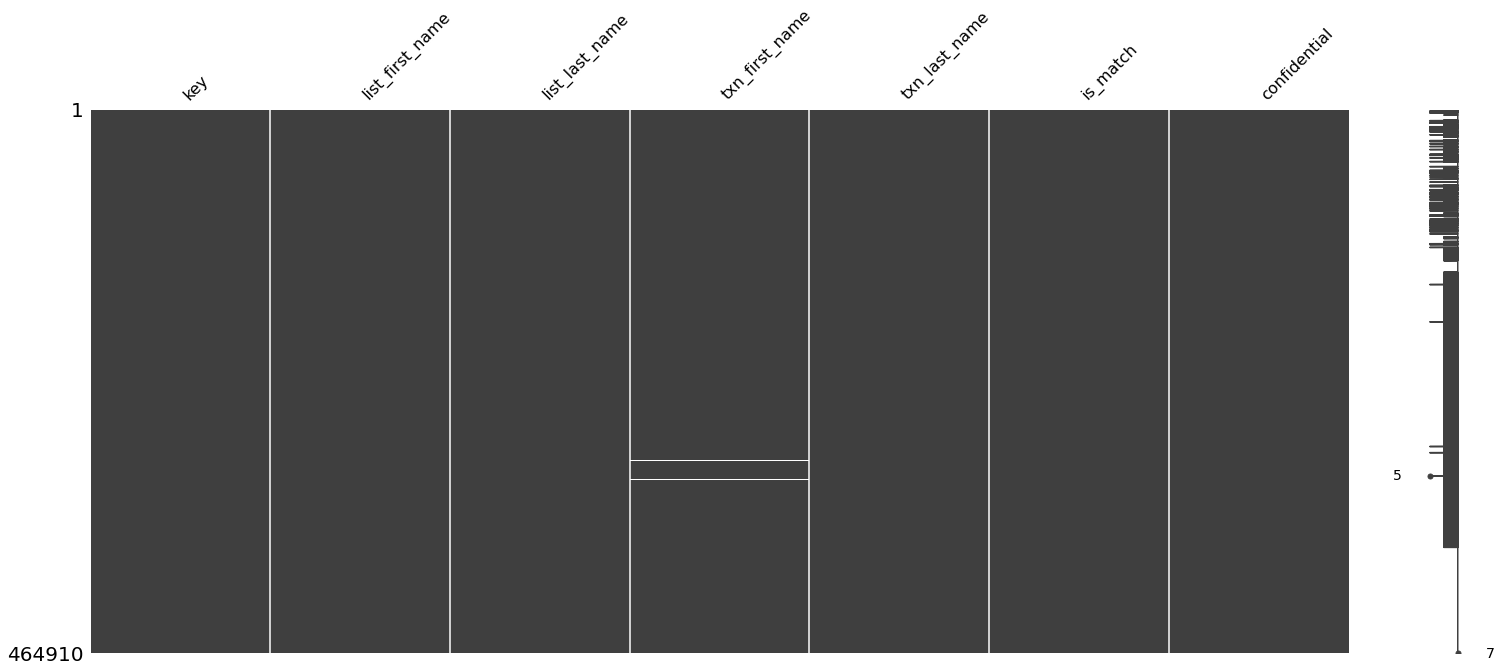

In [7]:
# Visualize missingness matrix
msno.matrix(df)
plt.show()

In [8]:
# Drop rows with missing data
df = df.dropna()

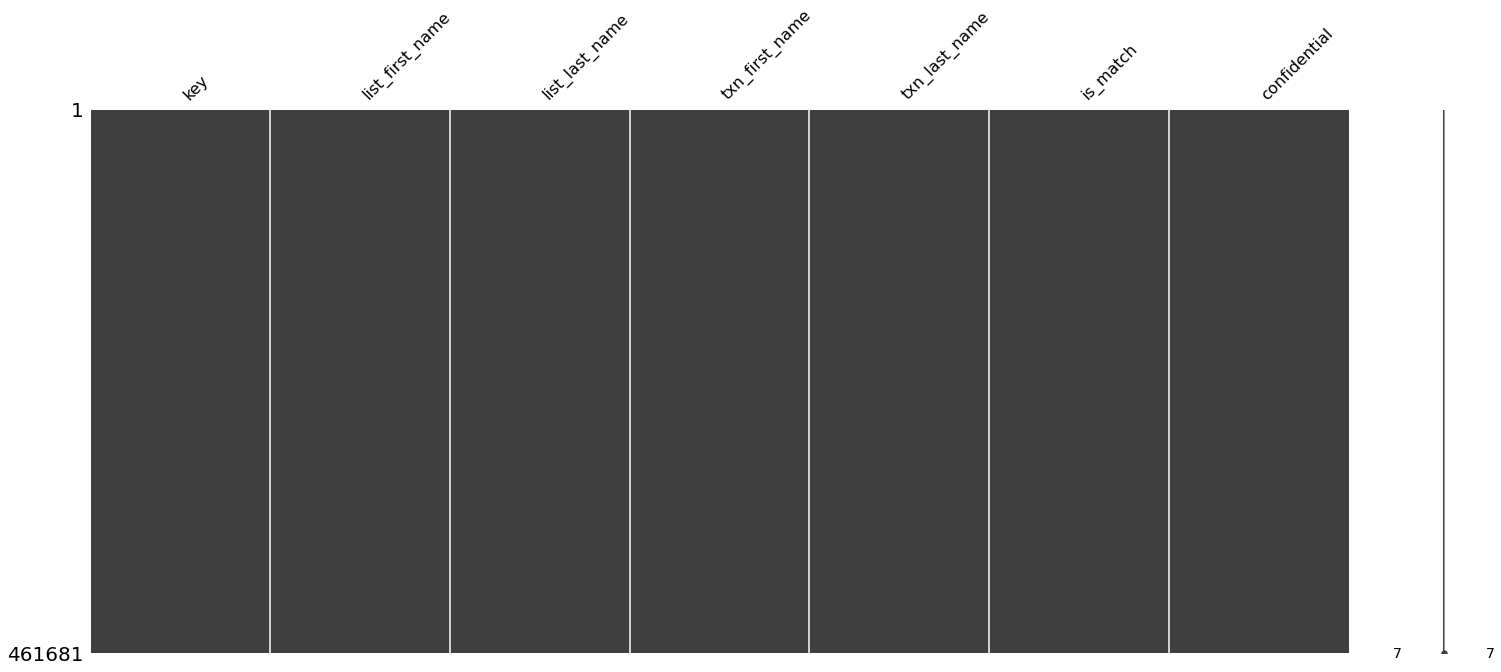

In [9]:
# Visualize missingness matrix
msno.matrix(df)
plt.show()

In [10]:
# Check if any names are numeric only
print("Number of numeric list first names: ", df[df.list_first_name.str.isnumeric()==True].shape[0])
print("Number of numeric list last names: ", df[df.list_last_name.str.isnumeric()==True].shape[0])
print("Number of numeric transaction first names: ", df[df.txn_first_name.str.isnumeric()==True].shape[0])
print("Number of numeric transaction last names: ", df[df.txn_last_name.str.isnumeric()==True].shape[0])

Number of numeric list first names:  733
Number of numeric list last names:  651
Number of numeric transaction first names:  94
Number of numeric transaction last names:  57


In [11]:
# Drop records with numeric names
df = df[df.list_first_name.str.isnumeric()==False]
df = df[df.list_last_name.str.isnumeric()==False]
df = df[df.txn_first_name.str.isnumeric()==False]
df = df[df.txn_last_name.str.isnumeric()==False]
df.shape

(460155, 7)

In [12]:
# Standardize names to upper case
df['list_first_name'] = df['list_first_name'].str.upper()
df['list_last_name'] = df['list_last_name'].str.upper()
df['txn_first_name'] = df['txn_first_name'].str.upper()
df['txn_last_name'] = df['txn_last_name'].str.upper()

#### Identify bad input records where names are completely different 

In [13]:
# Create fuzzy score for first name
df['is_match_first'] = df.apply(lambda x: (fuzz.ratio(x.list_first_name, x.txn_first_name))/100, axis=1)

In [14]:
# Create fuzzy score for last name
df['is_match_last'] = df.apply(lambda x: (fuzz.ratio(x.list_last_name, x.txn_last_name))/100, axis=1)

In [15]:
# Create fuzzy match score
df['match_score'] = df.is_match_first + df.is_match_last

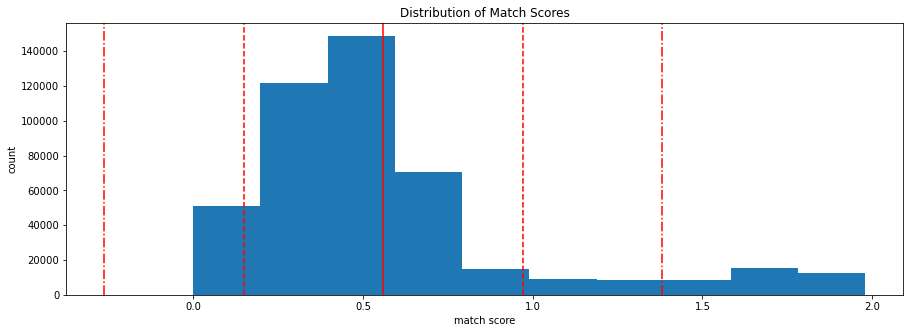

In [16]:
match_score_mean = df.match_score.mean()
match_score_std = df.match_score.std()
_ = plt.subplots(figsize=(15, 5))
_ = plt.hist(data=df, x='match_score')
_ = plt.xlabel('match score')
_ = plt.ylabel('count')
_ = plt.title('Distribution of Match Scores')
_ = plt.ticklabel_format(useOffset=False, style='plain')
_ = plt.axvline(match_score_mean, color='r')
_ = plt.axvline(match_score_mean+match_score_std, color='r', linestyle='--')
_ = plt.axvline(match_score_mean+(2*match_score_std), color='r', linestyle='-.')
_ = plt.axvline(match_score_mean-match_score_std, color='r', linestyle='--')
_ = plt.axvline(match_score_mean-(2*match_score_std), color='r', linestyle='-.')

In [17]:
def set_match(row):
    if row.match_score >= match_score_mean+(2*match_score_std):
        return 1
    else:
        return 0
df['is_match'] = df.apply(lambda x: set_match(x), axis=1)

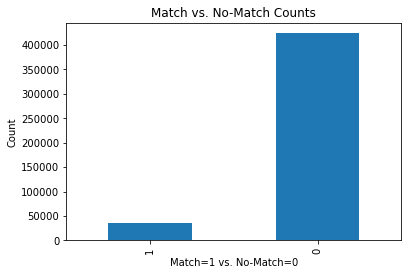

In [18]:
df.is_match.value_counts().sort_values().plot(kind='bar')
plt.title('Match vs. No-Match Counts')
plt.xlabel('Match=1 vs. No-Match=0')
plt.ylabel('Count')
plt.show()

#### Filter data by unique keys using max score

In [19]:
# Get unique keys with max match score
df_max = df.groupby('key').max('match_score')

In [20]:
# Merge match data with original data to get names
df_match = df[df.is_match==1].merge(df_max, on=['key', 'match_score'], how='inner')
df_match.shape

(32985, 14)

In [21]:
# Merge no-match data with original data to get names
df_no_match = df[df.is_match==0].merge(df_max, on=['key', 'match_score'], how='inner')
df_no_match.shape

(29109, 14)

In [22]:
# Concatenate the match and no-match data
df = df_match.append(df_no_match, ignore_index=True)
df.shape

(62094, 14)

In [23]:
# Drop duplicate columns from merge
df.drop(df.columns[7:], axis = 1, inplace=True)

In [24]:
# Rename columns that were suffixed by merge back to original column names
df = df.rename(columns={'is_match_x': 'is_match', 'confidential_x': 'confidential'})

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62094 entries, 0 to 62093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   key              62094 non-null  object
 1   list_first_name  62094 non-null  object
 2   list_last_name   62094 non-null  object
 3   txn_first_name   62094 non-null  object
 4   txn_last_name    62094 non-null  object
 5   is_match         62094 non-null  int64 
 6   confidential     62094 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.3+ MB


## Wrangle Synthetic / Non-Confidential Data

In [26]:
df2 = pd.read_csv(ext_data + 'name_pairs_first_last.csv')
df2.shape

(17510, 6)

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17510 entries, 0 to 17509
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   key              17510 non-null  int64 
 1   list_first_name  17510 non-null  object
 2   list_last_name   17508 non-null  object
 3   txn_first_name   17510 non-null  object
 4   txn_last_name    17508 non-null  object
 5   is_match         17510 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 820.9+ KB


In [28]:
df2['confidential'] = 0

In [29]:
# Standardize names to upper case
df2['list_first_name'] = df2['list_first_name'].str.upper()
df2['list_last_name'] = df2['list_last_name'].str.upper()
df2['txn_first_name'] = df2['txn_first_name'].str.upper()
df2['txn_last_name'] = df2['txn_last_name'].str.upper()

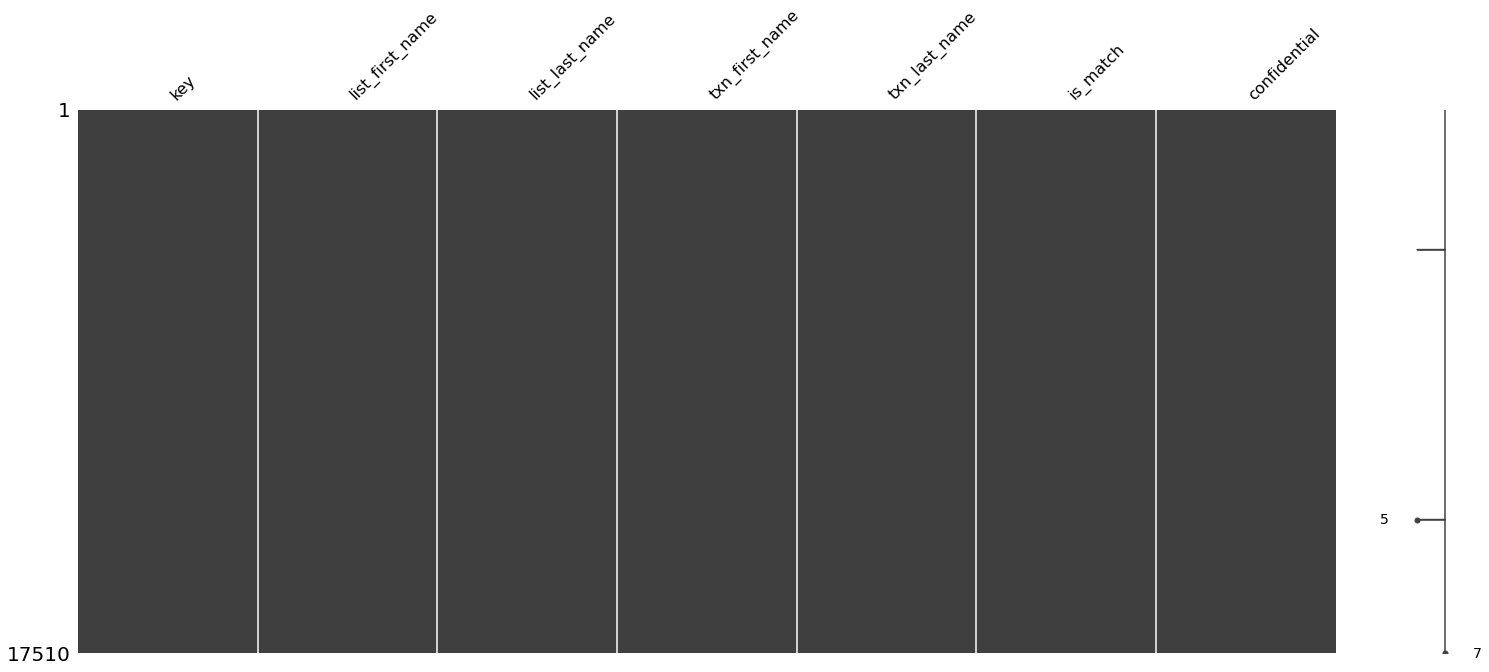

In [30]:
# Visualize missingness matrix
msno.matrix(df2)
plt.show()

In [31]:
# Drop rows with missing data
df2 = df2.dropna()
df2.shape

(17508, 7)

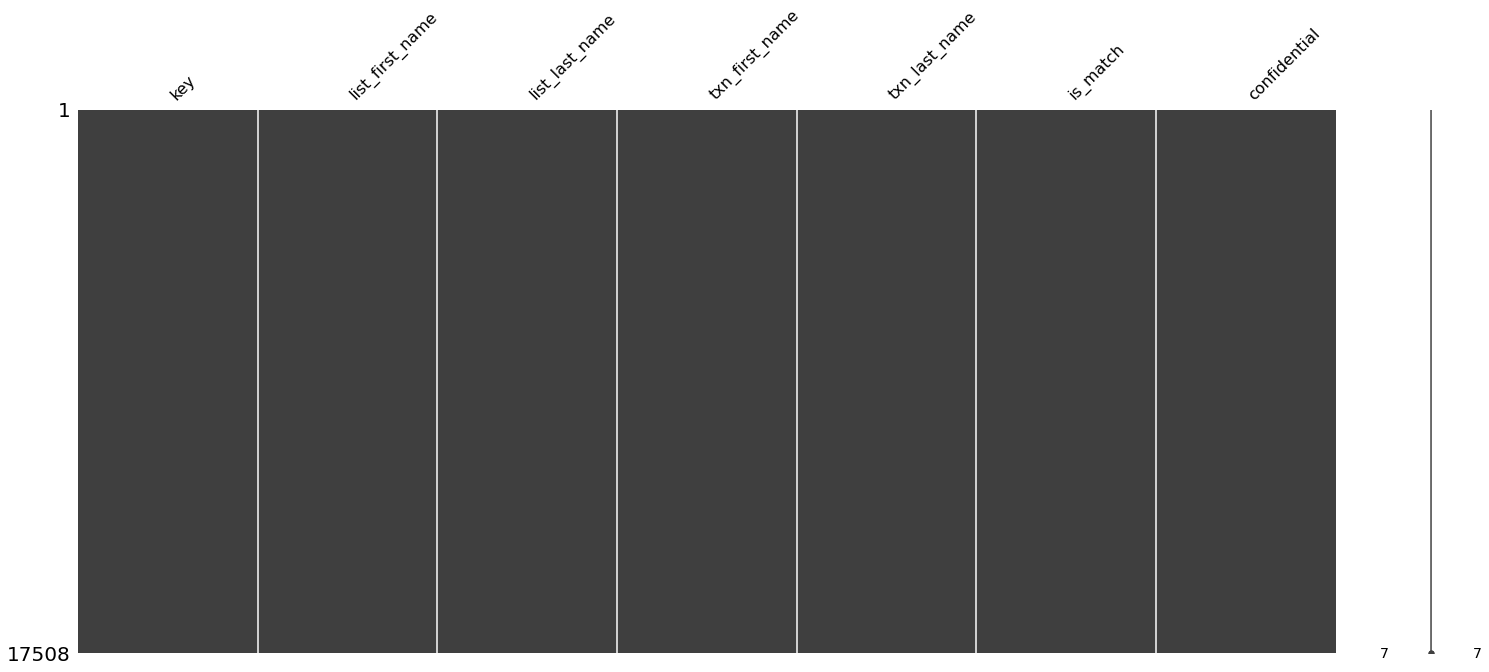

In [32]:
# Visualize missingness matrix
msno.matrix(df2)
plt.show()

In [33]:
df2.head()

,key,list_first_name,list_last_name,txn_first_name,txn_last_name,is_match,confidential
0,1,AAD,SMITH,ADRIAAN,SMITH,1,0
1,2,AAKE,JOHNSON,AARNE,JOHNSON,1,0
2,3,AAKE,WILLIAMS,AARNO,WILLIAMS,1,0
3,4,AAKE,JONES,ARSKA,JONES,1,0
4,5,AANDREA,BROWN,DREA,BROWN,1,0


#### Create synthetic no-match data

In [34]:
df2_no_match = df2.copy()
df2_no_match.shape

(17508, 7)

In [35]:
df2_no_match['is_match'] = 0

In [36]:
# Adjust keys so that they will not be duplicated with the match data
df2_no_match['key'] = df2_no_match.key + df2.shape[0] + 2

In [37]:
# Shuffle names
df2_no_match['txn_first_name'] = np.random.permutation(df2['txn_first_name'].values)
df2_no_match['txn_last_name'] = np.random.permutation(df2['txn_last_name'].values)
df2_no_match.head()

,key,list_first_name,list_last_name,txn_first_name,txn_last_name,is_match,confidential
0,17511,AAD,SMITH,LENA,MIRACLE,0,0
1,17512,AAKE,JOHNSON,RUTGER,STALNAKER,0,0
2,17513,AAKE,WILLIAMS,LOUISON,JUSTUS,0,0
3,17514,AAKE,JONES,SULLE,SALTERS,0,0
4,17515,AANDREA,BROWN,NICKY,FERRARA,0,0


In [38]:
# Concatenate the match and no-match data
df2 = df2.append(df2_no_match, ignore_index=True)
df2.shape

(35016, 7)

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35016 entries, 0 to 35015
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   key              35016 non-null  int64 
 1   list_first_name  35016 non-null  object
 2   list_last_name   35016 non-null  object
 3   txn_first_name   35016 non-null  object
 4   txn_last_name    35016 non-null  object
 5   is_match         35016 non-null  int64 
 6   confidential     35016 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.9+ MB


## Concatenate Real and Synthetic Data

In [40]:
# Concatenate the real and synthetic data
df = df.append(df2, ignore_index=True)
df.shape

(97110, 7)

In [41]:
# Save output to interim data folder as csv file
df.to_csv(interim_data + 'data_wrangling_results.csv', index=False)